In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
es = Elasticsearch(hosts=[{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

In [23]:
indices = es.cat.indices(index="jobs_archive_*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [x for x in indices if x != '']
print(indices)

['jobs_archive_2016-01-02', 'jobs_archive_2016-01-03', 'jobs_archive_2016-01-04', 'jobs_archive_2016-01-05', 'jobs_archive_2016-01-06', 'jobs_archive_2016-01-07', 'jobs_archive_2016-01-08', 'jobs_archive_2016-01-09', 'jobs_archive_2016-01-10', 'jobs_archive_2016-01-11', 'jobs_archive_2016-01-12', 'jobs_archive_2016-01-13', 'jobs_archive_2016-01-14', 'jobs_archive_2016-01-15', 'jobs_archive_2016-01-16', 'jobs_archive_2016-01-17', 'jobs_archive_2016-01-18', 'jobs_archive_2016-01-19', 'jobs_archive_2016-01-20', 'jobs_archive_2016-01-21', 'jobs_archive_2016-01-22', 'jobs_archive_2016-01-23', 'jobs_archive_2016-01-24', 'jobs_archive_2016-01-25', 'jobs_archive_2016-01-26', 'jobs_archive_2016-01-27', 'jobs_archive_2016-01-28', 'jobs_archive_2016-01-29', 'jobs_archive_2016-01-30', 'jobs_archive_2016-01-31', 'jobs_archive_2016-02-01_reindexed', 'jobs_archive_2016-02-02_reindexed', 'jobs_archive_2016-02-03_reindexed', 'jobs_archive_2016-02-04_reindexed', 'jobs_archive_2016-02-05_reindexed', 'job

In [24]:
def time_filter(indices, last_days=60, pattern=''):
    if last_days == 0:
        return ["jobs_archive_*"]
    filtered = []
    if pattern:
        for i in indices:
            if pattern in i:
                filtered.append(i.rstrip())
        return filtered
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%m-%d'
    for i in indices:
        if i.endswith("reindexed"):
            continue
        day = re.sub(r'jobs_archive_', '', i).rstrip()
        
        day = datetime.datetime.strptime(day, datefmt).date()
        diff = today - day
        if diff.days <= last_days:
            filtered.append(i.rstrip())
    return filtered

In [62]:
ind = time_filter(indices, 7, "" )
ind = ','.join(ind)
print(ind)

jobs_archive_2018-05-03,jobs_archive_2018-05-04,jobs_archive_2018-05-05,jobs_archive_2018-05-06,jobs_archive_2018-05-07,jobs_archive_2018-05-08,jobs_archive_2018-05-09,jobs_archive_2018-05-10


In [63]:
#q = "NOT produsername:gangarbt AND jobstatus:finished AND processingtype:reprocessing AND proddblock:*.00283429.*"
#q = "NOT produsername:gangarbt AND jobstatus:finished AND processingtype:pile"
q = "NOT produsername:gangarbt AND jobstatus:finished AND NOT transformation:*pandaserver* AND pilotid:*68.0* AND processingtype:reprocessing"

In [128]:
myquery = {
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "NOT produsername:gangarbt",
          "analyze_wildcard": True,
          "lowercase_expanded_terms": False
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "query": {
                "match": {
                  "processingtype": {
                    "query": "pile",
                    "type": "phrase"
                  }
                }
              }
            },
            {
              "query": {
                "match": {
                  "jobstatus": {
                    "query": "finished",
                    "type": "phrase"
                  }
                }
              }
            },
                     ]
        }
      }
    }
  },
  "size": 0,
  "aggs": {
    "2": {
      "histogram": {
        "script": "(doc['nevents'].value) ? doc['wall_time'].value*10/doc['nevents'].value : 0",
        "lang": "expression",
        "interval": 5
      },
      "aggs": {
        "3": {
          "significant_terms": {
            "field": "computingsite",
            "size": 10
          }
        }
      }
    }
  }
}


myqueryPile = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "NOT produsername:gangarbt AND NOT processingtype:*panda-client* AND NOT processingtype:*jedi*",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
        {
          "match": {
            "jobstatus": {
              "query": "finished",
              "type": "phrase"
            }
          }
        },
        {
          "match": {
            "processingtype": {
              "query": "pile",
              "type": "phrase"
            }
          }
        },
      ],
      "must_not": []
    }
  },
      "aggs": {
        "2": {
          "histogram": {
                        "script": {
          "inline": "doc['IOcharReadRate'].value/1048576.",
          "lang": "expression"
        },
            "interval": 0.1,
            "min_doc_count": 1
          },
          "aggs": {
            "3": {
              "significant_terms": {
                "field": "homepackage",
                "size": 20
              }
            }
          }
        }
      }

  }


myqueryPile2 = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "NOT produsername:gangarbt AND NOT processingtype:*panda-client* AND NOT processingtype:*jedi*",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
        {
          "match": {
            "jobstatus": {
              "query": "finished",
              "type": "phrase"
            }
          }
        },
        {
          "match": {
            "processingtype": {
              "query": "pile",
              "type": "phrase"
            }
          }
        },
      ],
      "must_not": []
    }
  },
      "aggs": {
        "2": {
                  "histogram": {
        "script": {
          "inline": "doc['IOcharRead'].value/1048576.",
          "lang": "expression"
        },
        "interval": 1,
            "min_doc_count": 1
          },
          "aggs": {
            "3": {
              "significant_terms": {
                "field": "homepackage",
                "size": 20
              }
            }
          }
        }
      }

  }

myqueryPile3 = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "NOT produsername:gangarbt AND NOT processingtype:*panda-client* AND NOT processingtype:*jedi*",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
        {
          "match": {
            "jobstatus": {
              "query": "finished",
              "type": "phrase"
            }
          }
        },
        {
          "match": {
            "processingtype": {
              "query": "pile",
              "type": "phrase"
            }
          }
        },
      ],
      "must_not": []
    }
  },
      "aggs": {
        "2": {
                  "histogram": {
        "script": {
          "inline": "doc['inputfilebytes'].value/1073741824.",
          "lang": "expression"
        },
        "interval": 0.5,
            "min_doc_count": 1
          },
          "aggs": {
            "3": {
              "significant_terms": {
                "field": "homepackage",
                "size": 20
              }
            }
          }
        }
      }

  }

myqueryWalltime = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "NOT produsername:gangarbt AND jobstatus:finished AND NOT transformation:*pandaserver* AND pilotid:*68.0* AND processingtype:reprocessing AND inputfiletype:RAW",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "histogram": {
        "script": {
          "inline": "(doc['nevents'].value && doc['actualcorecount'].value) ? doc['wall_time'].value*doc['actualcorecount'].value/doc['nevents'].value : 0",
          "lang": "expression"
        },
        "interval": 0.5,
        "min_doc_count": 1
      },
      "aggs": {
        "3": {
          "significant_terms": {
            "field": "computingsite",
            "size": 20
          }
        }
      }
    }
  }
}

myqueryWalltime2 = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "jobstatus:finished AND pilotid:*68* AND processingtype:reprocessing AND inputfiletype:RAW",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "histogram": {
        "script": {
          "inline": "(doc['nevents'].value && doc['actualcorecount'].value) ? doc['wall_time'].value*doc['actualcorecount'].value/doc['nevents'].value : 0",
          "lang": "expression"
        },
        "interval": 1,
        "min_doc_count": 1
      },
      "aggs": {
        "3": {
          "significant_terms": {
            "field": "computingsite",
            "size": 1000
          }
        }
      }
    }
  }
}

myqueryWalltime3 = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "NOT produsername:gangarbt AND jobstatus:finished AND NOT transformation:*pandaserver* AND pilotid:*68* AND processingtype:reprocessing AND inputfiletype:RAW",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "histogram": {
        "script": {
          "inline": "(doc['nevents'].value && doc['actualcorecount'].value) ? doc['wall_time'].value*doc['actualcorecount'].value/doc['nevents'].value : 0",
          "lang": "expression"
        },
        "interval": 1,
        "min_doc_count": 1
      }
    }
  }
}

myqueryWalltime4 = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "processingtype:reprocessing AND reqid:(15233 OR 15234 OR 15236 OR 15238) AND jobstatus:finished AND inputfiletype:RAW",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "histogram": {
        "script": {
          "inline": "(doc['nevents'].value && doc['actualcorecount'].value) ? doc['wall_time'].value*doc['actualcorecount'].value/doc['nevents'].value : 0",
          "lang": "expression"
        },
        "interval": 1,
        "min_doc_count": 1
      }
    }
  }
}

myqueryWalltime5 = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "processingtype:reprocessing AND reqid:(14729 OR 14730 OR 14731 OR 14732) AND jobstatus:finished AND inputfiletype:RAW",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "histogram": {
        "script": {
          "inline": "(doc['nevents'].value && doc['actualcorecount'].value) ? doc['wall_time'].value*doc['actualcorecount'].value/doc['nevents'].value : 0",
          "lang": "expression"
        },
        "interval": 1,
        "min_doc_count": 1
      }
    }
  }
}

myqueryIObytesReadRate1 = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "processingtype:deriv AND jobstatus:finished AND computingsite:CERN*",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "histogram": {
        "script": {
          "inline": "doc['IObytesReadRate'].value ? doc['IObytesReadRate'].value : 0",
          "lang": "expression"
        },
        "interval": 100000,
        "min_doc_count": 1
      }
    }
  }
}

myqueryIObytesReadRate2 = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "processingtype:pile AND jobstatus:finished AND computingsite:CERN*",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "histogram": {
        "script": {
          "inline": "doc['IObytesReadRate'].value ? doc['IObytesReadRate'].value : 0",
          "lang": "expression"
        },
        "interval": 100000,
        "min_doc_count": 1
      }
    }
  }
}

myqueryIObytesReadRate3 = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "jobstatus:finished AND NOT prodsourcelabel:managed AND NOT produsername:gangarbt",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "histogram": {
        "script": {
          "inline": "doc['IObytesReadRate'].value ? doc['IObytesReadRate'].value : 0",
          "lang": "expression"
        },
        "interval": 100000,
        "min_doc_count": 1
      }
    }
  }
}






In [129]:
res = es.search(index=ind, body=myqueryIObytesReadRate3, request_timeout=600)

In [130]:
print(res)

{'took': 73, 'aggregations': {'2': {'buckets': [{'doc_count': 30716, 'key': 0.0}, {'doc_count': 22005, 'key': 100000.0}, {'doc_count': 10218, 'key': 200000.0}, {'doc_count': 11884, 'key': 300000.0}, {'doc_count': 9378, 'key': 400000.0}, {'doc_count': 7409, 'key': 500000.0}, {'doc_count': 6508, 'key': 600000.0}, {'doc_count': 6649, 'key': 700000.0}, {'doc_count': 5534, 'key': 800000.0}, {'doc_count': 4442, 'key': 900000.0}, {'doc_count': 3628, 'key': 1000000.0}, {'doc_count': 3218, 'key': 1100000.0}, {'doc_count': 2919, 'key': 1200000.0}, {'doc_count': 2759, 'key': 1300000.0}, {'doc_count': 3062, 'key': 1400000.0}, {'doc_count': 2961, 'key': 1500000.0}, {'doc_count': 3027, 'key': 1600000.0}, {'doc_count': 2211, 'key': 1700000.0}, {'doc_count': 2736, 'key': 1800000.0}, {'doc_count': 2239, 'key': 1900000.0}, {'doc_count': 1608, 'key': 2000000.0}, {'doc_count': 2065, 'key': 2100000.0}, {'doc_count': 1708, 'key': 2200000.0}, {'doc_count': 1558, 'key': 2300000.0}, {'doc_count': 1781, 'key': 

mean = 8.130988946800834, sum = 222560, wsum = 1809632.8999999936
max = 30716, maxbin = 0 
len(xbins) = 3670, len(hists) = 1
['All'] 222560


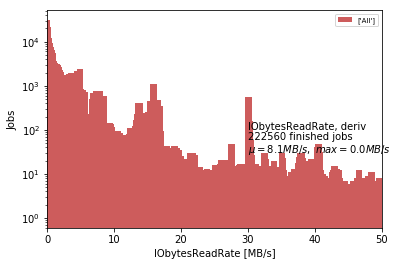

In [139]:
xbins = []
hists = [[]]
rels = [['All']]
    
# Now loop again and fill the histogram bins            
xbin = 0
for r in res['aggregations']['2']['buckets']:
    x = r['key']/1000000
    #if x>200: # This is the x-axis cut for total !
    #    continue
    xbins.append(x)
    for hist in hists:
        hist.append(r['doc_count'])
    xbin = xbin + 1

#print(hists)
#print(xbins)

f = open("ioreadrate_deriv.csv","w") 
for x,y in zip(xbins,hists[0]):
  f.write("%s,%s\n" %(x,y))
f.close()

allsites = hists[0]
ibin = 0
sum = 0
wsum = 0
max = 0
for bin in allsites:
    if bin > max:
        max = bin
        maxbin = ibin
    sum = sum + bin
    wsum = wsum + bin * ibin
    ibin = ibin + 0.1

mean = wsum/sum
print ("mean = %s, sum = %s, wsum = %s" %(mean, sum, wsum))
print ("max = %s, maxbin = %s " %(max, maxbin))
print("len(xbins) = %s, len(hists) = %s" %(len(xbins),len(hists)))

# Initialisation for histogram stacking
y_offset = np.array([0.0] * len(xbins))
#colors = plt.cm.BuPu(np.linspace(0, 0.5, len(hists)))
#allcolors = ('#ff3333', '#33ff33', '#3333ff', '#33ffff', "#ffffff", '#000000', '#ff0000', '#00ff00', '#0000ff')
#allcolors = ('accent', 'dark2', 'paired', 'pastel1','pastel2', 'set1', 'set2', 'set3', 'vega10','vega20', 'vega20b', 'vega20c')
#allcolors = [u'#4B0082', u'#FFD700', u'#FF69B4', u'#B22222', u'#CD5C5C', u'#87AE73', u'#FFFF00', u'#FFE4E1', u'#556B2F', u'#808000', u'#8FBC8F', u'#FFC0CB', u'#FF6347', u'#F08080', u'#FF4500', u'#FFDEAD', u'#00FF00', u'#98FB98', u'#2F4F4F', u'#ADFF2F', u'#DEB887', u'#FFF5EE', u'#00FA9A', u'#FF00FF', u'#FFEFD5', u'#FFEBCD', u'#7FFF00', u'#696969', u'#000000', u'#FFDAB9', u'#00FF7F', u'#7FFFD4', u'#FFFFFF', u'#FFA500', u'#FFA07A', u'#2F4F4F', u'#A52A2A', u'#FFFFF0', u'#1E90FF', u'#CD853F', u'#A9A9A9', u'#7CFC00', u'#D2691E', u'#DC143C', u'#228B22', u'#6A5ACD', u'#20B2AA', u'#00FFFF', u'#F5FFFA', u'#C0C0C0', u'#FAEBD7', u'#BA55D3', u'#87CEEB', u'#808080', u'#00CED1', u'#DAA520', u'#006400', u'#FFFAF0', u'#9400D3', u'#A9A9A9', u'#FFE4B5', u'#8B4513', u'#808080', u'#483D8B', u'#87CEFA', u'#FFB6C1', u'#C71585', u'#708090', u'#FF0000', u'#FF1493', u'#32CD32', u'#8B008B', u'#EEE8AA', u'#DDA0DD', u'#40E0D0', u'#D3D3D3', u'#FAFAD2', u'#B8860B', u'#E6E6FA', u'#800000', u'#9ACD32', u'#FAA460', u'#D8BFD8', u'#EE82EE', u'#000080', u'#FF00FF', u'#696969', u'#D2B48C', u'#BC8F8F', u'#6B8E23', u'#0000FF', u'#ADD8E6', u'#F8F8FF', u'#F0FFF0', u'#6495ED', u'#FAF0E6', u'#00008B', u'#B0E0E6', u'#2E8B57', u'#BDB76B', u'#FFFAFA', u'#A0522D', u'#0000CD', u'#4169E1', u'#E0FFFF', u'#008000', u'#9370DB', u'#191970', u'#FFF8DC', u'#AFEEEE', u'#FFE4C4', u'#708090', u'#008B8B', u'#F0E68C', u'#F5DEB3', u'#008080', u'#9932CC', u'#00BFFF', u'#FA8072', u'#8B0000', u'#4682B4', u'#DB7093', u'#778899', u'#F0F8FF', u'#778899', u'#90EE90', u'#DA70D6', u'#DCDCDC', u'#3CB371', u'#D3D3D3', u'#48D1CC', u'#598556', u'#FFFACD', u'#5F9EA0', u'#FFFFE0', u'#FFF0F5', u'#FF7F50', u'#800080', u'#00FFFF', u'#BCECAC', u'#F5F5F5', u'#7B68EE', u'#FF8C00', u'#66CDAA', u'#E9967A', u'#F5F5DC', u'#8A2BE2', u'#F0FFFF', u'#B0C4DE', u'#FDF5E6']
allcolors = [u'#CD5C5C', u'#8B0000', u'#FF0000', u'#FF4500', u'#C71585', u'#DB7093',u'#5F9EA0', u'#B0E0E6', u'#ADD8E6', u'#00BFFF', u'#87CEEB', u'#87CEFA', u'#4682B4', u'#F0F8FF', u'#1E90FF', u'#B0C4DE', u'#6495ED', u'#4169E1', u'#191970', u'#00008B', u'#0000CD', u'#0000FF', u'#6A5ACD', u'#483D8B', u'#7B68EE', u'#8A2BE2',u'#9ACD32', u'#556B2F', u'#ADFF2F', u'#7CFC00', u'#8FBC8F', u'#98FB98', u'#90EE90', u'#228B22', u'#32CD32', u'#006400', u'#008000', u'#2E8B57', u'#3CB371', u'#00FF7F', u'#00FA9A', u'#20B2AA']

#from itertools import cycle, islice
#allcolors = list(islice(cycle(['b', 'r', 'g', 'c', 'm', 'y', 'k', 'w']), None, len(hists)))

colors = allcolors[:len(hists)]
#print(colors)

for hist, rel, icolor in zip(hists,rels, colors):
    sum = 0
    for i in hist:
        sum = sum + i
    print (rel, sum )
    
for hist, rel, icolor in zip(hists, rels, colors):
    #print(hist,xbins)
    #plt.plot(xbins,hist)
    plt.bar(xbins, hist, bottom=y_offset, log=True, label=rel, color=icolor, width=1)
    #plt.bar(xbins, hist, log=False, label=rel, color=icolor, width=10)
    y_offset = y_offset + hist
    #print(hist)
    #plt.hist(hist,bins=xbins, log=True, label=rels[i])
    plt.xlabel('IObytesReadRate [MB/s]')
    plt.ylabel('Jobs')

plt.legend(loc='upper right',prop={'size':7})
plt.xlim([0,50])
plt.text(30, 100, r'IObytesReadRate, deriv')
plt.text(30, 60, r'%s finished jobs' %sum)
plt.text(30, 30, r'$\mu=%2.1f MB/s,\ max=%2.1f MB/s$'%(mean, maxbin))

plt.savefig("iobytesreadrate_deriv.png")
plt.show()



In [116]:
res2= es.search(index=ind, body=myqueryIObytesReadRate2, request_timeout=600)

[[5, 6, 7, 4, 5, 13, 19, 30, 43, 62, 87, 94, 88, 69, 64, 56, 60, 49, 44, 37, 37, 23, 34, 40, 28, 31, 22, 17, 24, 15, 22, 26, 29, 37, 17, 22, 25, 28, 31, 37, 24, 22, 23, 30, 34, 23, 17, 13, 13, 12, 19, 15, 14, 7, 6, 12, 10, 4, 5, 4, 7, 4, 2, 4, 3, 4, 2, 3, 2, 4, 1, 2, 3, 3, 2, 3, 2, 3, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
mean = 2.6166948674562884, sum = 1773, wsum = 4639.4
max = 94, maxbin = 1.0999999999999999 
len(xbins) = 98, len(hists) = 1
['All'] 1773


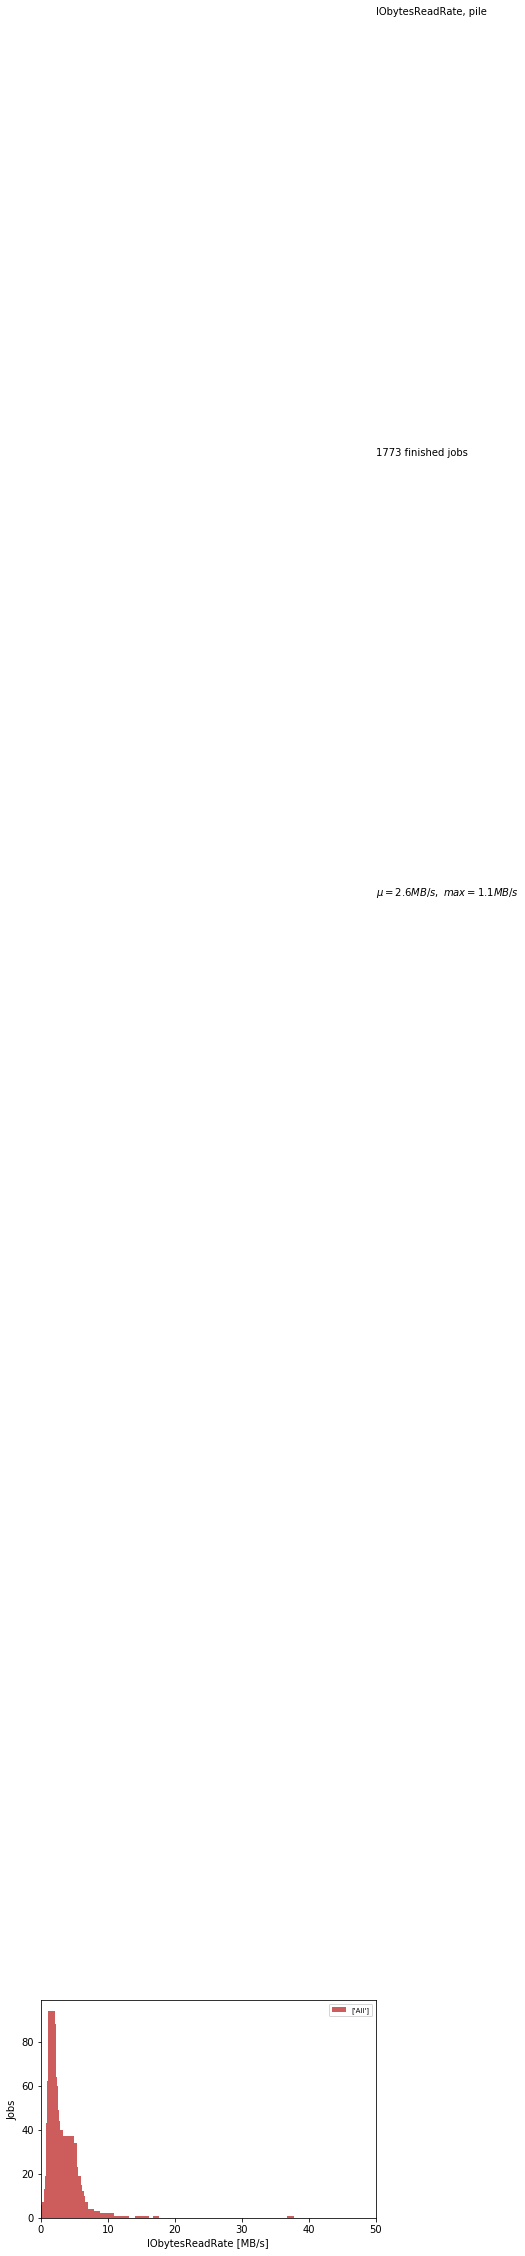

In [117]:
xbins2 = []
hists2 = [[]]
    
# Now loop again and fill the histogram bins            
xbin = 0
for r in res2['aggregations']['2']['buckets']:
    x = r['key']/1000000
    #if x>200: # This is the x-axis cut for total !
    #    continue
    xbins2.append(x)
    for hist in hists2:
        hist.append(r['doc_count'])
    xbin = xbin + 1

print(hists2)

allsites = hists2[0]
ibin = 0
sum2 = 0
wsum2 = 0
max2 = 0
for bin in allsites:
    if bin > max2:
        max2 = bin
        maxbin2 = ibin
    sum2 = sum2 + bin
    wsum2 = wsum2 + bin * ibin
    ibin = ibin + 0.1

mean2 = wsum2/sum2
print ("mean = %s, sum = %s, wsum = %s" %(mean2, sum2, wsum2))
print ("max = %s, maxbin = %s " %(max2, maxbin2))
print("len(xbins) = %s, len(hists) = %s" %(len(xbins2),len(hists2)))

# Initialisation for histogram stacking
y_offset = np.array([0.0] * len(xbins2))
#colors = plt.cm.BuPu(np.linspace(0, 0.5, len(hists)))
#allcolors = ('#ff3333', '#33ff33', '#3333ff', '#33ffff', "#ffffff", '#000000', '#ff0000', '#00ff00', '#0000ff')
#allcolors = ('accent', 'dark2', 'paired', 'pastel1','pastel2', 'set1', 'set2', 'set3', 'vega10','vega20', 'vega20b', 'vega20c')
#allcolors = [u'#4B0082', u'#FFD700', u'#FF69B4', u'#B22222', u'#CD5C5C', u'#87AE73', u'#FFFF00', u'#FFE4E1', u'#556B2F', u'#808000', u'#8FBC8F', u'#FFC0CB', u'#FF6347', u'#F08080', u'#FF4500', u'#FFDEAD', u'#00FF00', u'#98FB98', u'#2F4F4F', u'#ADFF2F', u'#DEB887', u'#FFF5EE', u'#00FA9A', u'#FF00FF', u'#FFEFD5', u'#FFEBCD', u'#7FFF00', u'#696969', u'#000000', u'#FFDAB9', u'#00FF7F', u'#7FFFD4', u'#FFFFFF', u'#FFA500', u'#FFA07A', u'#2F4F4F', u'#A52A2A', u'#FFFFF0', u'#1E90FF', u'#CD853F', u'#A9A9A9', u'#7CFC00', u'#D2691E', u'#DC143C', u'#228B22', u'#6A5ACD', u'#20B2AA', u'#00FFFF', u'#F5FFFA', u'#C0C0C0', u'#FAEBD7', u'#BA55D3', u'#87CEEB', u'#808080', u'#00CED1', u'#DAA520', u'#006400', u'#FFFAF0', u'#9400D3', u'#A9A9A9', u'#FFE4B5', u'#8B4513', u'#808080', u'#483D8B', u'#87CEFA', u'#FFB6C1', u'#C71585', u'#708090', u'#FF0000', u'#FF1493', u'#32CD32', u'#8B008B', u'#EEE8AA', u'#DDA0DD', u'#40E0D0', u'#D3D3D3', u'#FAFAD2', u'#B8860B', u'#E6E6FA', u'#800000', u'#9ACD32', u'#FAA460', u'#D8BFD8', u'#EE82EE', u'#000080', u'#FF00FF', u'#696969', u'#D2B48C', u'#BC8F8F', u'#6B8E23', u'#0000FF', u'#ADD8E6', u'#F8F8FF', u'#F0FFF0', u'#6495ED', u'#FAF0E6', u'#00008B', u'#B0E0E6', u'#2E8B57', u'#BDB76B', u'#FFFAFA', u'#A0522D', u'#0000CD', u'#4169E1', u'#E0FFFF', u'#008000', u'#9370DB', u'#191970', u'#FFF8DC', u'#AFEEEE', u'#FFE4C4', u'#708090', u'#008B8B', u'#F0E68C', u'#F5DEB3', u'#008080', u'#9932CC', u'#00BFFF', u'#FA8072', u'#8B0000', u'#4682B4', u'#DB7093', u'#778899', u'#F0F8FF', u'#778899', u'#90EE90', u'#DA70D6', u'#DCDCDC', u'#3CB371', u'#D3D3D3', u'#48D1CC', u'#598556', u'#FFFACD', u'#5F9EA0', u'#FFFFE0', u'#FFF0F5', u'#FF7F50', u'#800080', u'#00FFFF', u'#BCECAC', u'#F5F5F5', u'#7B68EE', u'#FF8C00', u'#66CDAA', u'#E9967A', u'#F5F5DC', u'#8A2BE2', u'#F0FFFF', u'#B0C4DE', u'#FDF5E6']
allcolors = [u'#CD5C5C', u'#8B0000', u'#FF0000', u'#FF4500', u'#C71585', u'#DB7093',u'#5F9EA0', u'#B0E0E6', u'#ADD8E6', u'#00BFFF', u'#87CEEB', u'#87CEFA', u'#4682B4', u'#F0F8FF', u'#1E90FF', u'#B0C4DE', u'#6495ED', u'#4169E1', u'#191970', u'#00008B', u'#0000CD', u'#0000FF', u'#6A5ACD', u'#483D8B', u'#7B68EE', u'#8A2BE2',u'#9ACD32', u'#556B2F', u'#ADFF2F', u'#7CFC00', u'#8FBC8F', u'#98FB98', u'#90EE90', u'#228B22', u'#32CD32', u'#006400', u'#008000', u'#2E8B57', u'#3CB371', u'#00FF7F', u'#00FA9A', u'#20B2AA']

#from itertools import cycle, islice
#allcolors = list(islice(cycle(['b', 'r', 'g', 'c', 'm', 'y', 'k', 'w']), None, len(hists)))

colors = allcolors[:len(hists)]
#print(colors)

for hist, rel, icolor in zip(hists2,rels, colors):
    sum2 = 0
    for i in hist:
        sum2 = sum2 + i
    print (rel, sum2 )
    
for hist, rel, icolor in zip(hists2, rels, colors):
    #print(hist,xbins)
    #plt.plot(xbins,hist)
    plt.bar(xbins2, hist, bottom=y_offset, log=False, label=rel, color=icolor, width=1)
    #plt.bar(xbins, hist, log=False, label=rel, color=icolor, width=10)
    y_offset = y_offset + hist
    #print(hist)
    #plt.hist(hist,bins=xbins, log=True, label=rels[i])
    plt.xlabel('IObytesReadRate [MB/s]')
    plt.ylabel('Jobs')

plt.legend(loc='upper right',prop={'size':7})
plt.xlim([0,50])
plt.text(50, 1000, r'IObytesReadRate, pile')
plt.text(50, 800, r'%s finished jobs' %sum2)
plt.text(50, 600, r'$\mu=%2.1f MB/s,\ max=%2.1f MB/s$'%(mean2, maxbin2))

plt.savefig("iobytesreadrate_pile.png")
plt.show()




277 98 277 98


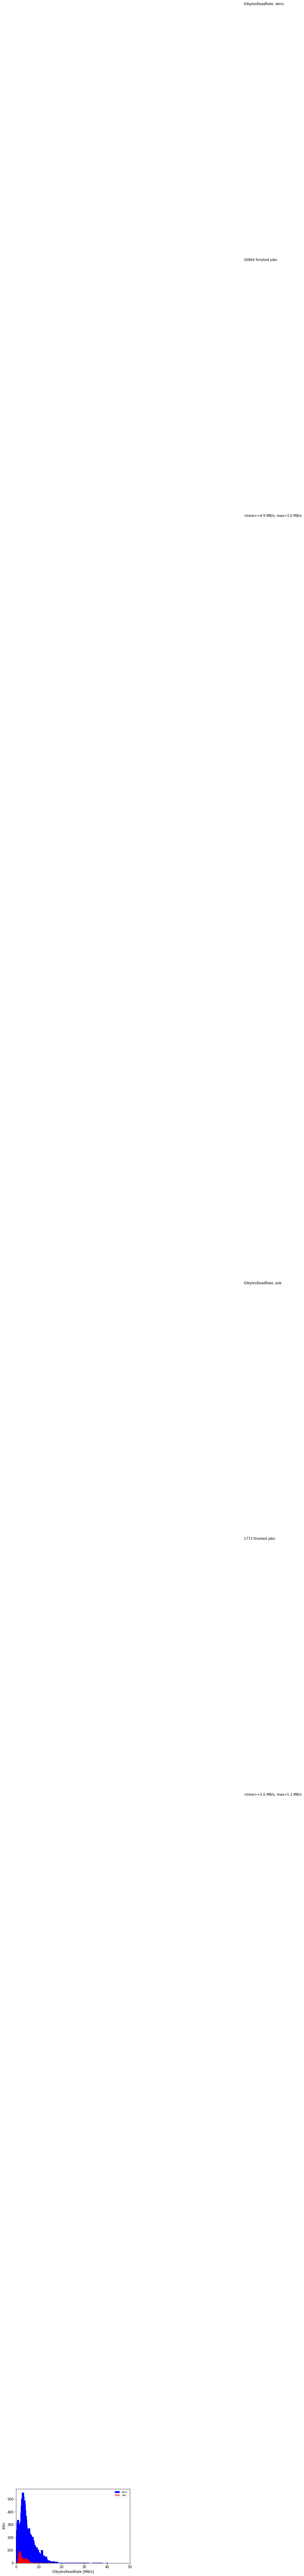

In [118]:
print (len(hists[0]), len(hists2[0]), len(xbins), len(xbins2))

allhists = [hists, hists2]
periods = ["deriv","pile"]

plt.bar(xbins, hists[0], log=False, label=periods[0], color="b", width=1, lw=1)
plt.bar(xbins2, hists2[0], log=False, label=periods[1], color="r", width=1, alpha =0.5, lw=1)

plt.xlabel('IObytesReadRate [MB/s]')
plt.ylabel('Jobs')

plt.legend(loc='upper right',prop={'size':7})
plt.xlim([0,50])
#plt.text(60, 6000, r'1st/2nd half, RAW input, finished jobs')
#plt.text(100, 8000, r'$\mu=%2.1f s,\ max=%s s$'%(mean, maxbin))

plt.text(100, 20000, r'IObytesReadRate, deriv')
plt.text(100, 18000, r'%s finished jobs' %sum)
plt.text(100, 16000, r'<time>=%2.1f MB/s, max=%2.1f MB/s'%(mean, maxbin))

plt.text(100, 10000, r'IObytesReadRate, pile')
plt.text(100, 8000, r'%s finished jobs' %sum2)
plt.text(100, 6000, r'<time>=%2.1f MB/s, max=%2.1f MB/s'%(mean2, maxbin2))





plt.savefig("iobytesreadrate_all.png")
plt.show()

